In [ ]:
'''
the original code you provided does not contain a training loop or training call. It primarily:

Downloads and prepares datasets.

Creates YOLO-format label files for pose keypoints.

Generates the dataset YAML config.

Visualizes annotations.

Loads a pretrained model.

Runs model validation (model_pose.val(...)).

There is no call to model.train() or any equivalent training loop in your original code.
'''

In [ ]:
#!pip install opencv-python


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from ultralytics import YOLO

model_path = "yolov8m-pose.pt"
model = YOLO(model_path)

# Try to print model config or keypoint info if available
print("Model Info:")
print(model.model)  # Prints model architecture and parameters

# If the model has a keypoints attribute or config, print it
if hasattr(model.model, 'kpt_shape'):
    print("Keypoint shape expected by model:", model.model.kpt_shape)
else:
    print("Keypoint shape info not directly available, check model docs or training config.")


In [ ]:
#!pip install ultralytics

In [1]:
import os 
import json
import time
import requests
import requests
from zipfile import ZipFile
import tarfile
from shutil import copyfile
from dataclasses import dataclass, field
import yaml
import glob
import random
import numpy as np
import pandas as pd
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt


In [2]:
def download_unzip(url,save_path):
    print("Downloading and extracting assets...",end="")
    file = requests.get(url)
    open(save_path,"wb").write(file.content)

    try:
        #Extract files
        if save_path.endswith(".tar"):
            with tarfile.open(save_path,"r") as tar:
                tar.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")


In [3]:
IMAGES_URL = r"http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
IMAGES_DIR = "Images"
IMAGES_TAR_PATH = os.path.join(os.getcwd(), f"{IMAGES_DIR}.tar")

ANNS_METADATA_URL = r"https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
ANNS_METADATA = "keypoint_definitions.csv"

# Download if dataset does not exists.
if not os.path.exists(IMAGES_DIR):
    download_unzip(IMAGES_URL, IMAGES_TAR_PATH)
    os.remove(IMAGES_TAR_PATH)

if not os.path.isfile(ANNS_METADATA):
    download_unzip(ANNS_METADATA_URL, ANNS_METADATA)


In [4]:
ANN_PATH = "StanfordExtra_V12"
JSON_PATH = os.path.join(ANN_PATH, "StanfordExtra_v12.json")

with open(JSON_PATH) as file:
    json_data = json.load(file)

In [5]:
train_ids = np.load(os.path.join(ANN_PATH,
                                 "train_stanford_StanfordExtra_v12.npy"))
val_ids = np.load(os.path.join(ANN_PATH,
                               "test_stanford_StanfordExtra_v12.npy"))

print(f"Train Samples: {len(train_ids)}")
print(f"Validation Samples: {len(val_ids)}")

Train Samples: 6773
Validation Samples: 1703


In [6]:
label_dir = "animal-pose-data/train/labels"

In [7]:
import os

# Paths to your dataset directories
train_img_dir = "animal-pose-data/train/images"
train_label_dir = "animal-pose-data/train/labels"
valid_img_dir = "animal-pose-data/valid/images"
valid_label_dir = "animal-pose-data/valid/labels"

def check_images_labels(img_dir, label_dir):
    img_files = set(os.listdir(img_dir))
    label_files = set(os.listdir(label_dir))

    # Remove file extensions to compare filenames
    img_basenames = {os.path.splitext(f)[0] for f in img_files}
    label_basenames = {os.path.splitext(f)[0] for f in label_files}

    imgs_without_labels = img_basenames - label_basenames
    labels_without_imgs = label_basenames - img_basenames

    if imgs_without_labels:
        print(f"Images without labels ({len(imgs_without_labels)}): {sorted(list(imgs_without_labels))}")
    else:
        print("All images have matching label files.")

    if labels_without_imgs:
        print(f"Labels without images ({len(labels_without_imgs)}): {sorted(list(labels_without_imgs))}")
    else:
        print("All label files have corresponding images.")

def check_empty_label_files(label_dir):
    empty_files = []
    for fname in os.listdir(label_dir):
        path = os.path.join(label_dir, fname)
        if os.path.getsize(path) == 0:
            empty_files.append(fname)
    if empty_files:
        print(f"Empty label files: {empty_files}")
    else:
        print("No empty label files found.")

def check_label_format(label_dir):
    for fname in os.listdir(label_dir):
        with open(os.path.join(label_dir, fname)) as f:
            for i, line in enumerate(f):
                line = line.strip()
                # Skip empty lines to catch unexpected blank lines
                if not line:
                    print(f"File {fname}, line {i+1} is empty (unexpected empty line).")
                    continue
                fields = line.split()
                if len(fields) != 77:
                    print(f"File {fname}, line {i+1} has {len(fields)} fields (expected 77).")

# Run checks
print("Checking train dataset:")
check_images_labels(train_img_dir, train_label_dir)
check_empty_label_files(train_label_dir)
check_label_format(train_label_dir)

print("\nChecking validation dataset:")
check_images_labels(valid_img_dir, valid_label_dir)
check_empty_label_files(valid_label_dir)
check_label_format(valid_label_dir)


# Check model and YAML config consistency
import yaml

yaml_path = "animal-keypoints.yaml"
with open(yaml_path) as f:
    yaml_data = yaml.safe_load(f)

print("\nYAML dataset configuration:")
print(yaml_data)

expected_kpt_shape = [24, 3]
actual_kpt_shape = yaml_data.get('kpt_shape', None)

if actual_kpt_shape != expected_kpt_shape:
    print(f"WARNING: kpt_shape in YAML is {actual_kpt_shape}, expected {expected_kpt_shape}. Please verify.")

# Note: Confirm your model checkpoint 'yolov8m-pose.pt' expects 24 keypoints in its config or as documented.
print("\nPlease verify model 'yolov8m-pose.pt' expects 24 keypoints (usually documented or in model release notes).")


Checking train dataset:
All images have matching label files.
All label files have corresponding images.
No empty label files found.

Checking validation dataset:
All images have matching label files.
All label files have corresponding images.
No empty label files found.

YAML dataset configuration:
{'kpt_shape': [24, 3], 'names': {0: 'dog'}, 'path': 'c:\\Users\\aliza\\Desktop\\og_behaviour\\yolo\\animal-pose-data', 'train': 'train\\images', 'val': 'valid\\images'}

Please verify model 'yolov8m-pose.pt' expects 24 keypoints (usually documented or in model release notes).


In [8]:
import os


for fname in os.listdir(label_dir):
    with open(os.path.join(label_dir, fname)) as f:
        for i, line in enumerate(f):
            fields = line.strip().split()
            if len(fields) != 77:
                print(f"File {fname}, line {i+1} has {len(fields)} fields (should be 77)")


In [9]:
for fname in os.listdir(label_dir):
    if os.path.getsize(os.path.join(label_dir, fname)) == 0:
        print(f"File {fname} is empty!")


In [10]:
print(type(train_ids))
print(train_ids)
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])


<class 'numpy.ndarray'>
[ 910  917  920 ... 8977 9745 9742]


In [11]:
DATA_DIR = "animal-pose-data"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)


In [12]:
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])

In [13]:
for data in train_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(TRAIN_IMG_PATH, filename))


for data in val_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(VALID_IMG_PATH, filename))

In [14]:
CLASS_ID = 0

In [15]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [16]:
def create_yolo_txt_files(json_data, LABEL_PATH):

    for data in json_data:

        IMAGE_ID = data["img_path"].split("/")[-1].split(".")[0]

        IMG_WIDTH, IMG_HEIGHT = data["img_width"], data["img_height"]

        landmark_kpts  = np.nan_to_num(np.array(data["joints"], dtype=np.float32))
        landmarks_bboxes = np.array(data["img_bbox"], dtype=np.float32)

        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = IMAGE_ID+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [17]:
create_yolo_txt_files(train_json_data, TRAIN_LABEL_PATH)
create_yolo_txt_files(val_json_data, VALID_LABEL_PATH)

In [18]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [19]:
train_images = os.listdir(TRAIN_IMG_PATH)
valid_images = os.listdir(VALID_IMG_PATH)

print(f"Training images: {len(train_images)}, Validation Images: {len(valid_images)}")

Training images: 6773, Validation Images: 1703


In [20]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [21]:
def draw_boxes(image, detections, class_name = "dog", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

In [22]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

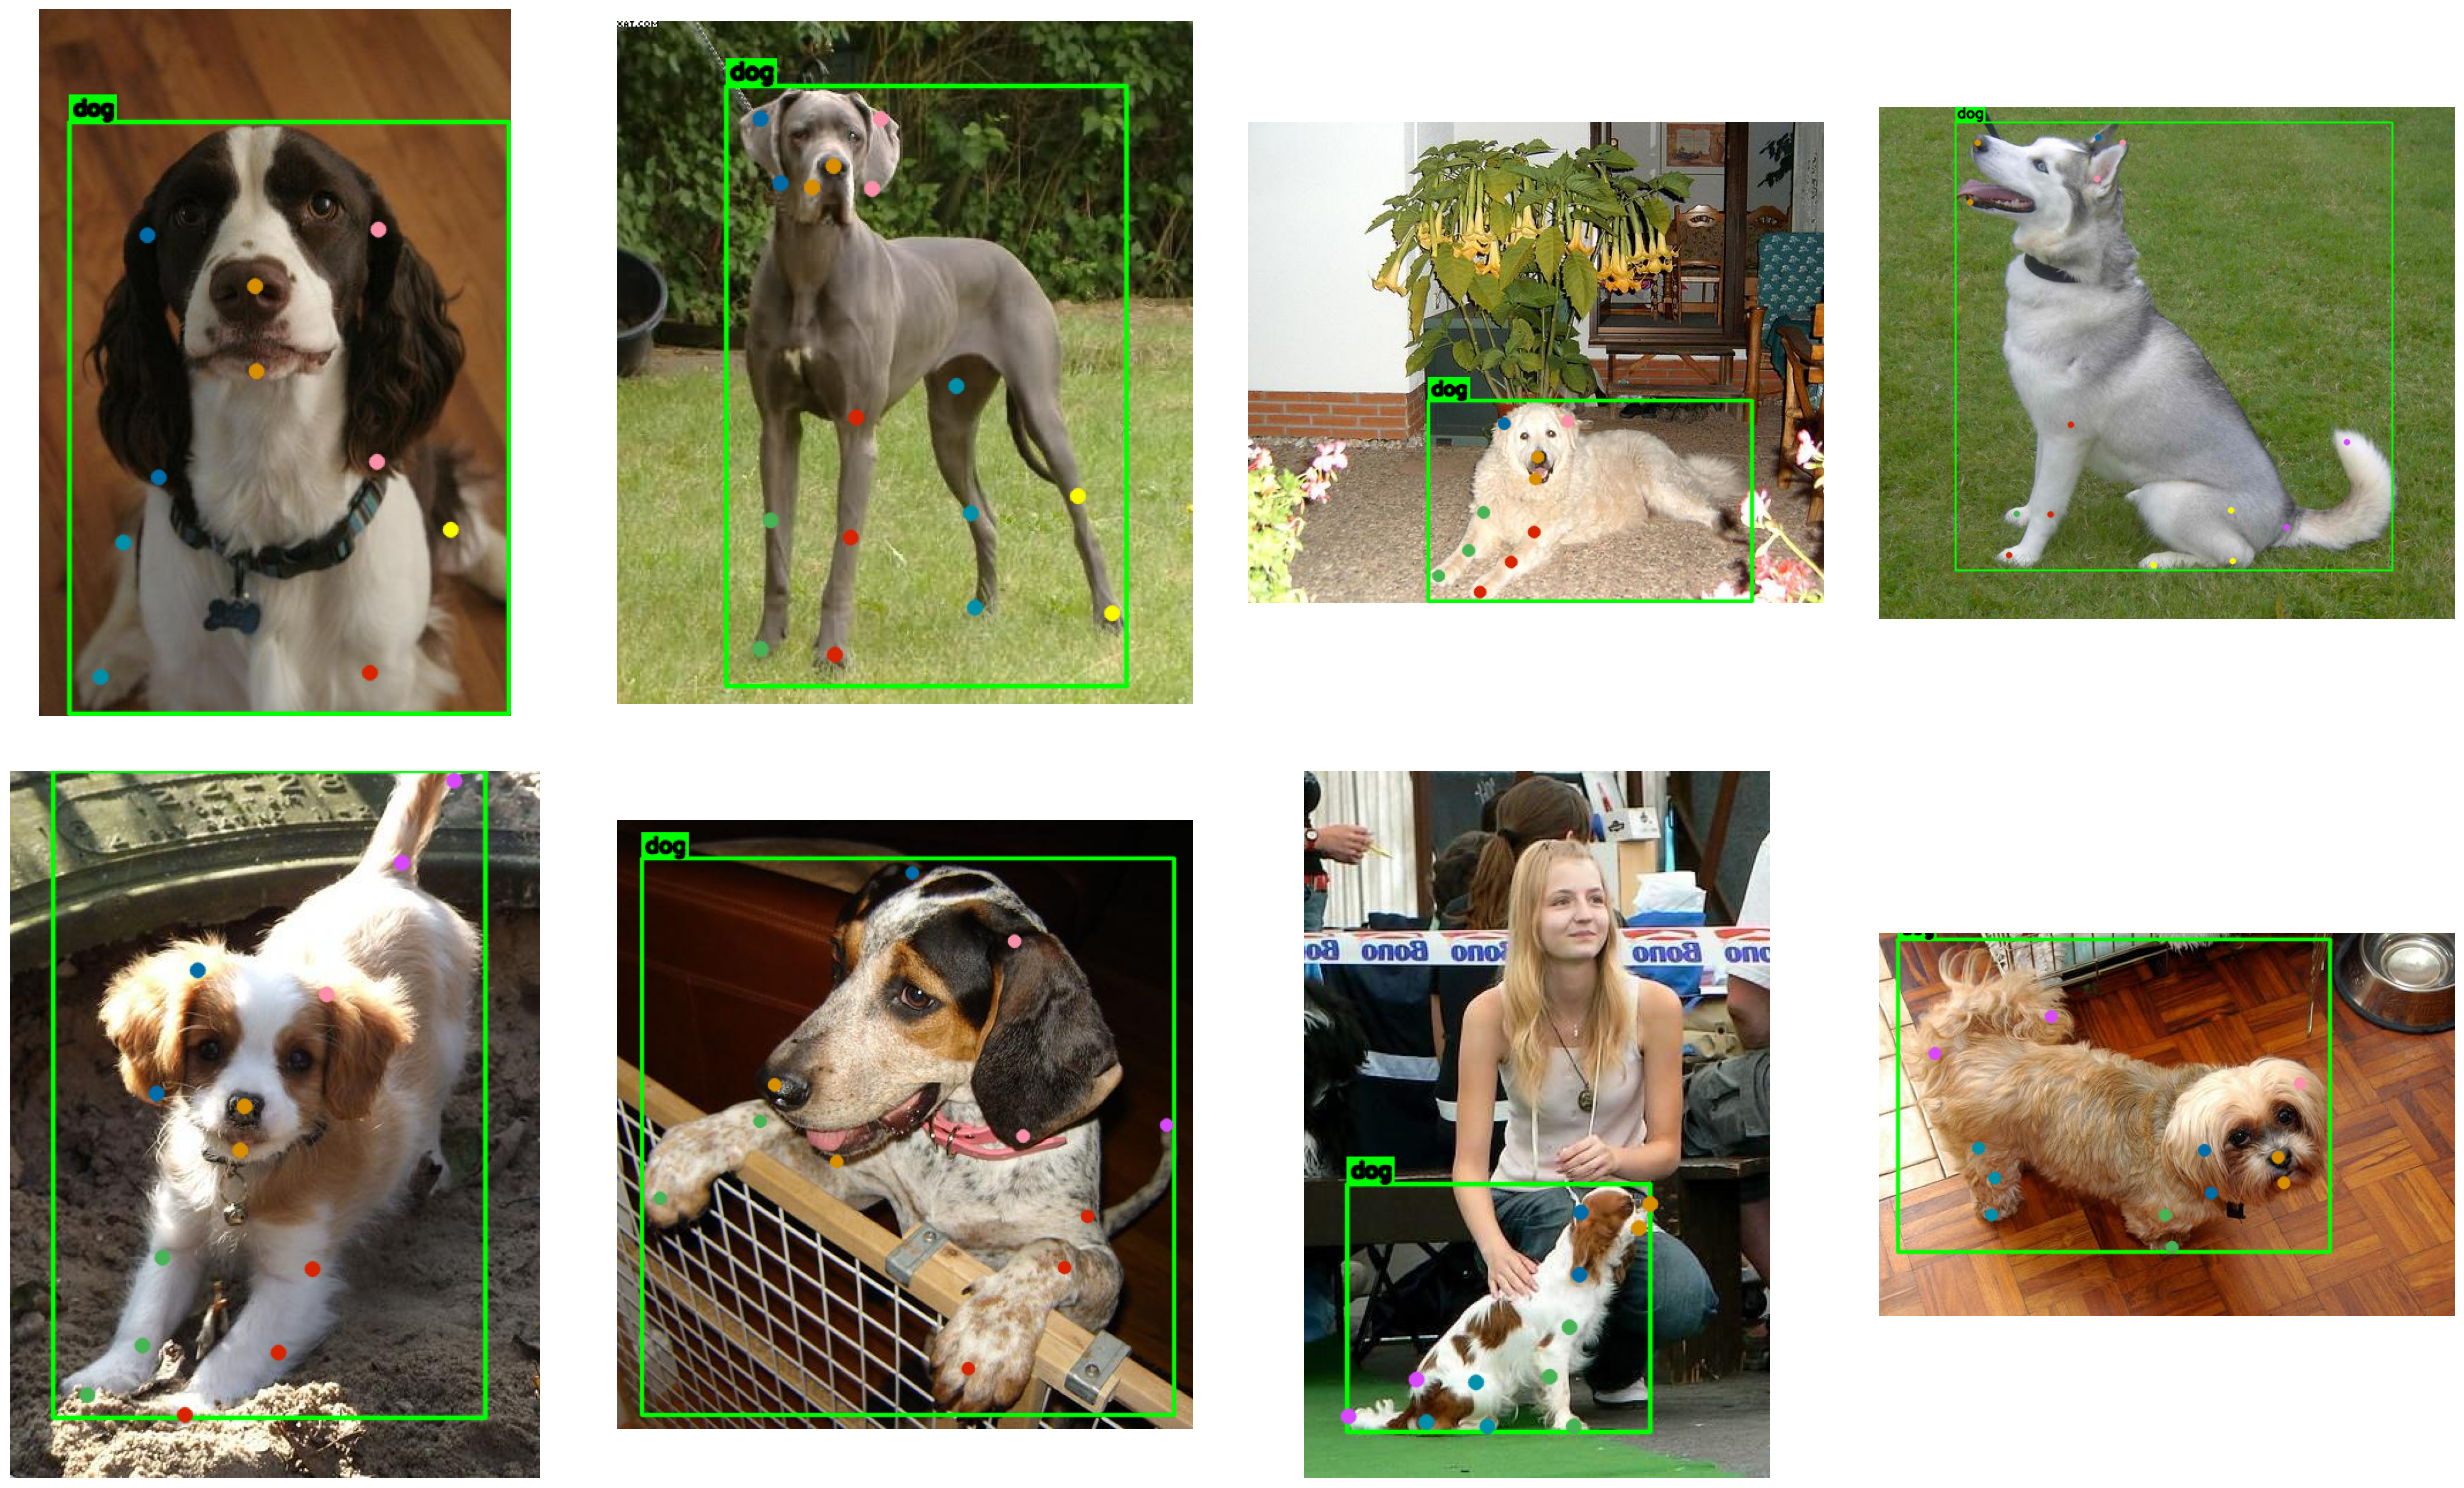

In [23]:
IMAGE_FILES = os.listdir(TRAIN_IMG_PATH)
NUM_LANDMARKS = 24

num_samples = 8
num_rows = 2
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(45)
random.shuffle(IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(IMAGE_FILES[:num_samples], ax.flat)):

    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, file))

    # Obtain the txt file for the corresponding image file.
    filename = file.split(".")[0]
    # Split each object instance in separate lists.
    with open(os.path.join(TRAIN_LABEL_PATH, filename+".txt"), "r") as file:
        label_data = [x.split() for x in file.read().strip().splitlines() if len(x)]

    label_data = np.array(label_data, dtype=np.float32)

    # YOLO BBox instances in [x-center, y-center, width, height] in normalized form.
    box_instances = label_data[:,1:5]
    # Shape: (N, 4), where, N = #instances per-image

    # Kpt instances.
    # Filter keypoints based on visibility.
    instance_kpts = []
    kpts_data = label_data[:,5:].reshape(-1, NUM_LANDMARKS, 3)

    for inst_kpt in kpts_data:
        vis_ids = np.where(inst_kpt[:, -1]>0.)[0]
        vis_kpts = inst_kpt[vis_ids][:,:2]
        vis_kpts = np.concatenate([vis_kpts, np.expand_dims(vis_ids, axis=-1)], axis=-1)
        instance_kpts.append(vis_kpts)

    image_ann = visualize_annotations(image, box_instances, instance_kpts)
    axis.imshow(image_ann[...,::-1])
    axis.axis("off")


plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

In [24]:

print(label_data.shape)  # Should be (num_instances, 5 + 24*3)
print(label_data)     # Check the length of each annotation


(1, 77)
[[          0       0.408      0.4262       0.748     0.81627           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0        0.51     0.82129           2
            0           0           0       0.498     0.73494           2       0.194     0.73494           2     0.20067     0.63956           2       0.174     0.56325           2       0.096     0.31476           2       0.299     0.21837           2       0.732     0.39257           2     0.56533     0.56727
            2     0.69333     0.58635           2     0.70333     0.65361           2           0           0           0     0.57763     0.67875           2           0           0           0           0           0           0           0           0           0           0           0           0]]


In [25]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "animal-keypoints.yaml"
    MODEL:          str = "yolov8m-pose.pt"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (24,3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "dog"})

In [26]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [27]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [ ]:
current_dir = os.getcwd()

data_dict = dict(
                path      = os.path.join(current_dir, DATA_DIR),
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

: 

In [ ]:
from ultralytics import YOLO

# Load the model (can be pretrained or a custom model)
model = YOLO('yolov8m-pose.pt')  # or "yolov8m-pose.pt" if local

# Train the model on your dataset and YAML config
results = model.train(
    data='animal-keypoints.yaml',  # Your dataset YAML path
    epochs=100,                    # Number of training epochs
    imgsz=640,                    # Image size
    batch=16,                     # Batch size
    name='yolov8m_pose_24kpts',   # Project/experiment name
                       # GPU device, or 'cpu' if no GPU
)

print("Training complete. Results:", results)


Ultralytics 8.3.199  Python-3.10.5 torch-2.8.0+cpu CPU (Intel Core(TM) i3-2350M 2.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=animal-keypoints.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_pose_24kpts2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [31]:
import sys
sys.path.append(r"C:\Users\aliza\Desktop\og_behaviour")   
#sys.path.append(r'C:\Users\aliza\Desktop\og_behaviour\yolo\animal-keypoints.yaml')


In [33]:
ckpt_path  = "./yolov8m-pose.pt"
model_pose = YOLO(ckpt_path)

metrics = model_pose.val(data="animal-keypoints.yaml")

#metrics = model_pose.val(data="yolo/animal-keypoints.yaml")
#metrics = model_pose.val(data="yolo/animal-keypoints.yaml")


Ultralytics 8.3.199  Python-3.10.5 torch-2.8.0+cpu CPU (Intel Core(TM) i3-2350M 2.30GHz)
YOLOv8m-pose summary (fused): 101 layers, 26,447,596 parameters, 0 gradients, 81.0 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1.80.3 MB/s, size: 21.8 KB)
val: Scanning C:\Users\aliza\Desktop\og_behaviour\yolo\animal-pose-data\valid\labels... 1703 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1703/1703 54.4it/s 31.3s<0.1s
val: C:\Users\aliza\Desktop\og_behaviour\yolo\animal-pose-data\valid\images\n02089973_1763.jpg: corrupt JPEG restored and saved
val: New cache created: C:\Users\aliza\Desktop\og_behaviour\yolo\animal-pose-data\valid\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 0% ──────────── 0/107  49.2s


RuntimeError: shape '[-1, 24, 3]' is invalid for input of size 102

In [ ]:
!pip install --upgrade ultralytics
size should be for n obj n*24*3

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ----------------------------- ---------- 0.8/1.1 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.5 MB/s  0:00:00
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.0/39.5 MB 2.3 MB/s eta 0:00:17
   - -------------------------------------- 1.6/39.5 MB 2.5 MB/s eta 0:00:15
   -- ------------------------------------- 2.1/39.5 MB 2.4 MB/s eta 0:00:16
   -- ------------------------------------- 2.6/39.5 MB 2.5 MB/s eta 0:00:15
   --- ------------------------------------ 3.4/39.5 MB 2.7 MB/s eta 0:00:14
   --- ------------------------------------ 3.9/39.5 MB 2.7 MB/s eta 0:00:13
   ---- ----------------------------------- 4.7/39.5 MB 2.7 MB/s eta 0:00:13
   ----- -------------------------